Notebook ini berisi materi **opsional** yang dapat memperkaya analisa terhadap data. Fokus dari notebook ini adalah analisis pada produk seperti **price elasticity** dan **market basket**

# Libraries

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from tqdm import tqdm
from sklearn.linear_model import ElasticNetCV
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import fpgrowth, association_rules

# Functions

In [2]:
def fit_ols_sku(sku):
    grp = groups[sku]
    X = sm.add_constant(grp[['log_price']])  # add intercept term
    y = grp['log_qty']

    model = sm.OLS(y, X).fit()
    return {
        'sku_name':      sku,
        'intercept':   model.params['const'],
        'elasticity':  model.params['log_price'],
        'p_value':     model.pvalues['log_price'],
        'r2':          model.rsquared,
        'n_obs':       len(grp),
        'n_price_pts': grp['log_price'].nunique(),
    }

def plot_sku_elasticity(sku_name, df_agg):
    grp = df_agg[df_agg['sku_name'] == sku_name]
    
    if grp.empty or grp['avg_price'].nunique() < 2:
        print(f"Not enough variation in price for SKU: {sku_name}")
        return

    # Prepare log-log regression
    X_log = sm.add_constant(grp['log_price'])
    y_log = grp['log_qty']
    model = sm.OLS(y_log, X_log).fit()

    # Extract coefficients
    beta_0 = model.params['const']
    beta_1 = model.params['log_price']
    r2 = model.rsquared

    # Generate line on original scale: Q = e^β₀ * P^β₁
    x_vals = np.linspace(grp['avg_price'].min(), grp['avg_price'].max(), 100)
    y_vals = np.exp(beta_0) * (x_vals ** beta_1)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='avg_price', y='total_qty', data=grp, s=60, alpha=0.7)
    plt.plot(x_vals, y_vals, color='red', label=f'Fit: Q = exp({beta_0:.2f}) * P^{beta_1:.2f}')

    # Labels and styling
    plt.title(f'SKU: {sku_name} | Elasticity = {beta_1:.2f} | R² = {r2:.2f}', fontsize=14)
    plt.xlabel('Price', fontsize=12)
    plt.ylabel('Quantity', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

# Load Data

In [3]:
df = pd.read_parquet('data/preprocessed/cleaned_data.parquet')

# Remove invalid order
df = df[(~df['order_id_adjustment'])&
(~df['sku_id_no_digit'])&
(~df['order_id_cancelled'])]

# Price Elasticity

In [4]:
# Aggregate sales per day per SKU
df_agg = (
    df
    .groupby(['sku_name', 'order_date_only'])
    .agg(
        avg_price=('adjusted_price', 'mean'), # Focus on price and quantity
        total_qty=('quantity', 'sum'), 
    )
    .reset_index()
)

# Transformasi log agar efek dalam persentase kenaikan
df_agg = (
    df_agg[(df_agg['avg_price'] > 0) & (df_agg['total_qty'] > 0)]
    .assign(
        log_price=lambda d: np.log(d['avg_price']),
        log_qty  =lambda d: np.log(d['total_qty'])
    )
)

# Exclude SKU dengan distinct price <3 atau observasi <10
sku_stats = (
    df_agg
    .groupby('sku_name')
    .agg(
        n_obs=('log_qty','size'),
        n_price_pts=('log_price','nunique')
    )
)
eligible_skus = sku_stats.query('n_price_pts >= 3 and n_obs >= 10').index

# Convert group menjadi dictionary untuk performance
groups = { sku: grp for sku, grp in df_agg.groupby('sku_name') if sku in eligible_skus }


results = []
for sku in tqdm(eligible_skus, desc="Fitting OLS"):
    try:
        results.append(fit_ols_sku(sku))
    except Exception as e:
        print(f"Failed to fit SKU {sku}: {e}")

elas_reg_df = pd.DataFrame(results)

Fitting OLS:   3%|██                                                               | 108/3360 [00:00<00:09, 359.59it/s]C:\Users\PC\anaconda3\envs\Kalbe\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
Fitting OLS:   8%|████▉                                                            | 255/3360 [00:00<00:08, 358.01it/s]C:\Users\PC\anaconda3\envs\Kalbe\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
Fitting OLS:  21%|█████████████▌                                                   | 703/3360 [00:01<00:07, 367.31it/s]C:\Users\PC\anaconda3\envs\Kalbe\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
Fitting OLS:  25%|████████████████▍                       

In [5]:
# Save the data
elas_reg_df[['sku_name','intercept','elasticity','p_value','r2','n_obs','n_price_pts']].reset_index(drop=True).to_parquet('data/preprocessed/price_elasticity.parquet')

In [6]:
elas_reg_df.sort_values('r2',ascending=False)

,sku_name,intercept,elasticity,p_value,r2,n_obs,n_price_pts
328,BLUE BREAKFAST CUP AND SAUCER,2.903283,-1.794721,1.812594e-14,0.916925,26,5
1128,FRENCH STYLE WALL DRESSER,12.686865,-2.622661,1.431495e-06,0.910960,12,3
306,BLACK SILVER FLOWER T-LIGHT HOLDER,1.942658,-2.181980,2.055683e-11,0.910598,21,5
249,BEAUTY SPEED EXPRESSO CUPS,4.164476,-2.053029,1.814271e-05,0.910583,10,5
1890,ORIGAMI VANILLA INCENSE+FLOWER,2.849000,-1.919224,2.549563e-06,0.900163,12,5
...,...,...,...,...,...,...,...
122,AMBER GLASS/SHELL/PEARL NECKLACE,0.000000,0.000000,NaN,NaN,14,3
286,BLACK DROP EARRINGS W LONG BEADS,0.000000,0.000000,NaN,NaN,14,4
730,CRACKED GLAZE EARRINGS BROWN,0.000000,0.000000,NaN,NaN,10,4
877,DOTCOMGIFTSHOP GIFT VOUCHER £30.00,0.000000,0.000000,NaN,NaN,24,3


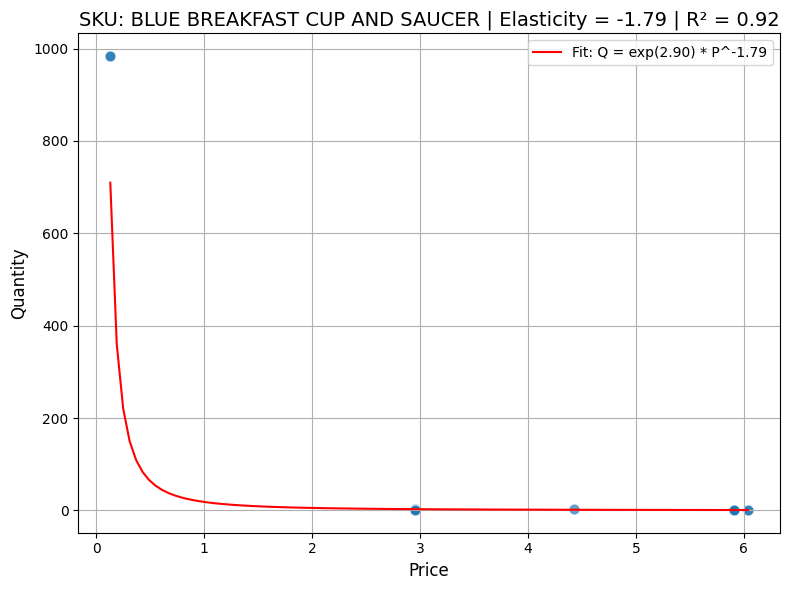

In [7]:
plot_sku_elasticity(sku_name='BLUE BREAKFAST CUP AND SAUCER',df_agg=df_agg)

Price elasticity di sku_id ini adalah -1.78, yang artinya, kenaikan 1% harga berkorespondensi terhadap penurunan quantity yang terjual sebesar 1.78%

# Market Basket

In [8]:
df = df[['order_id','sku_name','order_date_only','quantity']]

# --- Parameters
MIN_SUPPORT    = 0.01   # 1% minimum support
MIN_CONFIDENCE = 0.30   # 30% minimum confidence
MIN_LIFT       = 1.20   # 1.2 minimum lift

# --- Step 1: Filter last 3 months
df['order_date_only'] = pd.to_datetime(df['order_date_only'])
max_date    = df['order_date_only'].max()
cutoff_date = max_date - pd.DateOffset(months=3)
df_recent   = df[df['order_date_only'] >= cutoff_date]

# --- Step 2: Build boolean basket
basket = (
    df_recent
    .groupby(['order_id','sku_name'])['quantity']
    .sum()
    .unstack(fill_value=0)
    .astype(bool)
)

# --- Step 3: Mine frequent itemsets up to size 3
frequent_itemsets = fpgrowth(
    basket,
    min_support=MIN_SUPPORT,
    use_colnames=True,
    max_len=3
)

# --- Step 4: Generate association rules with min_confidence
rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=MIN_CONFIDENCE
)

# --- Step 5: Optional lift filter & size filter
rules = (
    rules[
        (rules['lift'] >= MIN_LIFT) &
        (rules['antecedents'].apply(len).isin([1,2]))  # 1→1 gives 2-item rules; 2→1 gives 3-item
    ]
    .copy()
)

# --- Step 6: Sort by confidence descending
rules_sorted = rules.sort_values('confidence', ascending=False).reset_index(drop=True)

# --- Step 7: Tidy up for display
rules_sorted['antecedents'] = rules_sorted['antecedents'].apply(lambda s: ', '.join(s))
rules_sorted['consequents'] = rules_sorted['consequents'].apply(lambda s: ', '.join(s))
display_cols = ['antecedents','consequents','support','confidence','lift']

rules_sorted[['antecedents','consequents','support','confidence']].to_parquet('data/preprocessed/market_basket.parquet')